In [3]:
# Download the dataset
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip

# Unzip the dataset
!unzip -o -q bank.zip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score
)

In [5]:
# Install and import imblearn for SMOTE
!pip install -q imblearn
from imblearn.over_sampling import SMOTE

In [6]:
# Import TensorFlow and Keras for Neural Network
!pip install -q tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Load and Preprocess the Data

# Read the bank-full.csv
data = pd.read_csv("bank-full.csv", sep=';')

# Display the first few rows
print("First 5 rows of the dataset:")
print(data.head())

# Display dataset information
print("\nDataset Information:")
print(data.info())

# Display class distribution before preprocessing
print("\nClass Distribution Before Preprocessing:")
print(data['y'].value_counts())


First 5 rows of the dataset:
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entr

In [8]:
# Drop 'duration' to Avoid Data Leakage

# In realistic scenarios, 'duration' is unknown at the time of prediction.
if 'duration' in data.columns:
    data = data.drop(['duration'], axis=1)
    print("\n'Duration' column dropped to prevent data leakage.")
else:
    print("\n'Duration' column not found in the dataset.")


'Duration' column dropped to prevent data leakage.


In [9]:
# Handle Missing Values
# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# If missing values exist, handle them
if missing_values.sum() > 0:
    # For numerical columns, fill with median
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    data[numerical_cols] = data[numerical_cols].fillna(data[numerical_cols].median())

    # For categorical columns, fill with mode
    categorical_cols = data.select_dtypes(include=['object']).columns
    data[categorical_cols] = data[categorical_cols].fillna(data[categorical_cols].mode().iloc[0])
    print("\nMissing values have been handled.")
else:
    print("\nNo missing values found.")



Missing Values in Each Column:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

No missing values found.


In [10]:
# Outlier Detection and Handling for 'previous' Column
# Detect and cap outliers in the 'previous' column using the IQR method
if 'previous' in data.columns:
    Q1 = data['previous'].quantile(0.25)
    Q3 = data['previous'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Capping the outliers
    data['previous'] = np.where(data['previous'] < lower_bound, lower_bound, data['previous'])
    data['previous'] = np.where(data['previous'] > upper_bound, upper_bound, data['previous'])
    print("\nOutliers in 'previous' column have been capped.")
else:
    print("\n'previous' column not found in the dataset.")


Outliers in 'previous' column have been capped.


In [11]:
# Handle 'pdays' Column
# 'pdays' - number of days that passed after the client was last contacted from a previous campaign
# -1 indicates that the client was not previously contacted

# Create a new binary feature indicating if the client was previously contacted
data['previously_contacted'] = np.where(data['pdays'] == -1, 0, 1)

# Replace -1 in 'pdays' with 0 for scaling purposes
data['pdays'] = data['pdays'].replace(-1, 0)

print("\n'previously_contacted' feature created and 'pdays' values adjusted.")



'previously_contacted' feature created and 'pdays' values adjusted.


In [12]:
# Feature Engineering on Numeric Columns
# Define numeric columns
numeric_cols = ['age', 'pdays', 'previous', 'balance', 'campaign', 'day']

# Create new ratio-based features, handling potential division by zero
data['age_balance_ratio'] = data['age'] / (data['balance'] + 1e-6)  # Adding a small constant to avoid division by zero
data['campaign_balance_ratio'] = data['campaign'] / (data['balance'] + 1e-6)
data['previous_campaign_ratio'] = data['previous'] / (data['campaign'] + 1e-6)

print("\nFeature engineering on numeric columns completed.")


Feature engineering on numeric columns completed.


In [13]:
# Encode Categorical Variables
# Identify categorical columns (excluding the target variable 'y')
categorical_cols = data.drop('y', axis=1).select_dtypes(include=['object']).columns
print("\nCategorical Columns:", categorical_cols.tolist())

# One-Hot Encoding for categorical variables
X = pd.get_dummies(data.drop('y', axis=1), columns=categorical_cols, drop_first=True)
print("\nShape of feature matrix after one-hot encoding:", X.shape)

# Convert target variable to binary
y = data['y'].map({'yes': 1, 'no': 0})

# Display class distribution before SMOTE
print("\nClass Distribution Before SMOTE:")
print(y.value_counts())


Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

Shape of feature matrix after one-hot encoding: (45211, 45)

Class Distribution Before SMOTE:
y
0    39922
1     5289
Name: count, dtype: int64


In [14]:
# Apply SMOTE for Oversampling Before Scaling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nClass Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts())


Class Distribution After SMOTE:
y
0    39922
1    39922
Name: count, dtype: int64


In [15]:
# Scale Only Numerical Features
# Define all numeric columns including the newly created features
scaled_numeric_cols = [
    'age', 'pdays', 'previous', 'balance', 'campaign', 'day',
    'age_balance_ratio', 'campaign_balance_ratio', 'previous_campaign_ratio'
]

# Check if all scaled_numeric_cols are in X_resampled
missing_scaled_numeric = set(scaled_numeric_cols) - set(X_resampled.columns)
if missing_scaled_numeric:
    print(f"\nWarning: The following numerical columns are missing and will be skipped for scaling: {missing_scaled_numeric}")
    scaled_numeric_cols = list(set(scaled_numeric_cols) - missing_scaled_numeric)
else:
    print("\nAll numeric columns identified for scaling.")



All numeric columns identified for scaling.


In [16]:
# Extract numerical columns for scaling
X_numerical = X_resampled[scaled_numeric_cols]

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numerical features
X_numerical_scaled = scaler.fit_transform(X_numerical)

# Create a DataFrame for scaled numerical features
X_numerical_scaled_df = pd.DataFrame(
    X_numerical_scaled,
    columns=scaled_numeric_cols,
    index=X_resampled.index
)

# Drop original numerical columns from X_resampled
X_resampled = X_resampled.drop(columns=scaled_numeric_cols)

# Concatenate scaled numerical features with the rest of the data
X_resampled = pd.concat([X_resampled, X_numerical_scaled_df], axis=1)

print("\nShape of feature matrix after scaling numerical features:", X_resampled.shape)



Shape of feature matrix after scaling numerical features: (79844, 45)


In [17]:
# Split the Data into Train and Test Sets
X_final = X_resampled
y_final = y_resampled

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=y_final
)

print("\nTraining Set Class Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTesting Set Class Distribution:")
print(pd.Series(y_test).value_counts())


Training Set Class Distribution:
y
1    31938
0    31937
Name: count, dtype: int64

Testing Set Class Distribution:
y
0    7985
1    7984
Name: count, dtype: int64


In [18]:
# Train and Evaluate a Random Forest Model with Default Parameters
# Initialize the Random Forest classifier with default parameters
default_rf = RandomForestClassifier(random_state=42)

# Train the model
default_rf.fit(X_train, y_train)
print("\nDefault Random Forest model has been trained.")

# Make predictions on the test set
rf_default_pred_test = default_rf.predict(X_test)

# Make predictions on the training set
rf_default_pred_train = default_rf.predict(X_train)



Default Random Forest model has been trained.


In [19]:
# Calculate evaluation metrics for training set
rf_default_accuracy_train = accuracy_score(y_train, rf_default_pred_train)
rf_default_recall_train = recall_score(y_train, rf_default_pred_train)
rf_default_precision_train = precision_score(y_train, rf_default_pred_train)
rf_default_f1_train = f1_score(y_train, rf_default_pred_train)
rf_default_auc_train = roc_auc_score(y_train, default_rf.predict_proba(X_train)[:,1])

In [20]:
# Calculate evaluation metrics for test set
rf_default_accuracy_test = accuracy_score(y_test, rf_default_pred_test)
rf_default_recall_test = recall_score(y_test, rf_default_pred_test)
rf_default_precision_test = precision_score(y_test, rf_default_pred_test)
rf_default_f1_test = f1_score(y_test, rf_default_pred_test)
rf_default_auc_test = roc_auc_score(y_test, default_rf.predict_proba(X_test)[:,1])

In [21]:
# Display evaluation metrics for training set
print("\n=========================")
print("DEFAULT RANDOM FOREST TRAINING SET RESULTS")
print("=========================")
print(f"Training Accuracy: {rf_default_accuracy_train:.4f}")
print(f"Training Recall: {rf_default_recall_train:.4f}")
print(f"Training Precision: {rf_default_precision_train:.4f}")
print(f"Training F1-Score: {rf_default_f1_train:.4f}")
print(f"Training AUC-ROC: {rf_default_auc_train:.4f}")
print("\nTraining Confusion Matrix:")
print(confusion_matrix(y_train, rf_default_pred_train))
print("\nTraining Classification Report:")
print(classification_report(y_train, rf_default_pred_train))


DEFAULT RANDOM FOREST TRAINING SET RESULTS
Training Accuracy: 1.0000
Training Recall: 1.0000
Training Precision: 1.0000
Training F1-Score: 1.0000
Training AUC-ROC: 1.0000

Training Confusion Matrix:
[[31937     0]
 [    0 31938]]

Training Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     31937
           1       1.00      1.00      1.00     31938

    accuracy                           1.00     63875
   macro avg       1.00      1.00      1.00     63875
weighted avg       1.00      1.00      1.00     63875



In [22]:
# Display evaluation metrics for test set
print("\n=========================")
print("DEFAULT RANDOM FOREST TEST SET RESULTS")
print("=========================")
print(f"Test Accuracy: {rf_default_accuracy_test:.4f}")
print(f"Test Recall: {rf_default_recall_test:.4f}")
print(f"Test Precision: {rf_default_precision_test:.4f}")
print(f"Test F1-Score: {rf_default_f1_test:.4f}")
print(f"Test AUC-ROC: {rf_default_auc_test:.4f}")
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, rf_default_pred_test))
print("\nTest Classification Report:")
print(classification_report(y_test, rf_default_pred_test))


DEFAULT RANDOM FOREST TEST SET RESULTS
Test Accuracy: 0.9356
Test Recall: 0.9092
Test Precision: 0.9599
Test F1-Score: 0.9339
Test AUC-ROC: 0.9758

Test Confusion Matrix:
[[7682  303]
 [ 725 7259]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      7985
           1       0.96      0.91      0.93      7984

    accuracy                           0.94     15969
   macro avg       0.94      0.94      0.94     15969
weighted avg       0.94      0.94      0.94     15969



In [23]:
# Hyperparameter Tuning for Random Forest using RandomizedSearchCV
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='roc_auc',
    cv=3,  # 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV to the training data
print("\nStarting RandomizedSearchCV for Hyperparameter Tuning...")
random_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params_rf = random_search.best_params_
print("\nBest Parameters Found for Random Forest:")
print(best_params_rf)


Starting RandomizedSearchCV for Hyperparameter Tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Parameters Found for Random Forest:
{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


In [24]:
# Fit the Random Forest model with best parameters on the entire training set
best_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    bootstrap=best_params_rf['bootstrap'],
    random_state=42
)

best_rf.fit(X_train, y_train)
print("\nRandom Forest model trained with best parameters.")


Random Forest model trained with best parameters.


In [25]:
# Extract feature importances
importances = best_rf.feature_importances_
feature_names = X_final.columns
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20 features
top_features = feature_importances.head(20)
print("\nTop 20 Features based on Feature Importances:")
print(top_features)


Top 20 Features based on Feature Importances:
                Feature  Importance
34     poutcome_success    0.090980
15   education_tertiary    0.075693
14  education_secondary    0.065052
12      marital_married    0.063207
39              balance    0.050765
13       marital_single    0.050123
36                  age    0.046158
41                  day    0.045453
1       job_blue-collar    0.034942
37                pdays    0.034139
4        job_management    0.032846
40             campaign    0.028505
28            month_mar    0.025155
31            month_oct    0.024378
9        job_technician    0.022918
22            month_aug    0.021281
5           job_retired    0.018875
29            month_may    0.018724
32            month_sep    0.017615
26            month_jul    0.017533


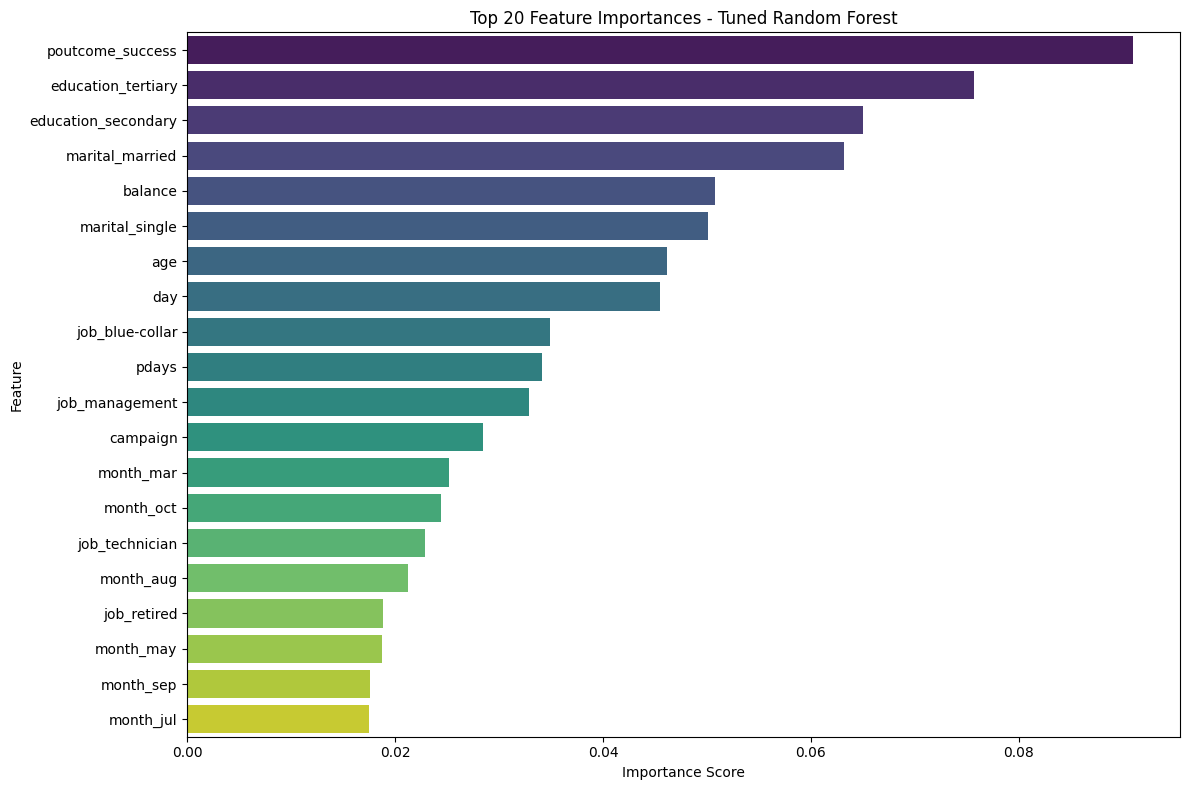

In [26]:
# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title("Top 20 Feature Importances - Tuned Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [27]:
# Select top N features (e.g., top 20)
selected_features = top_features['Feature'].tolist()

# Reduce the training and testing data to selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"\nShape of training data after feature selection: {X_train_selected.shape}")
print(f"Shape of testing data after feature selection: {X_test_selected.shape}")


Shape of training data after feature selection: (63875, 20)
Shape of testing data after feature selection: (15969, 20)


In [28]:
# Retrain Random Forest with Selected Features
# Initialize the Random Forest with best parameters
final_rf = RandomForestClassifier(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    bootstrap=best_params_rf['bootstrap'],
    random_state=42
)

# Train the model
final_rf.fit(X_train_selected, y_train)
print("\nRandom Forest model retrained with selected features.")



Random Forest model retrained with selected features.


In [29]:
# Make Predictions and Evaluate the Final Random Forest Model
# Make predictions on the test set
rf_final_pred_test = final_rf.predict(X_test_selected)

# Make predictions on the training set
rf_final_pred_train = final_rf.predict(X_train_selected)


In [30]:
# Calculate evaluation metrics for test set
rf_final_accuracy_test = accuracy_score(y_test, rf_final_pred_test)
rf_final_recall_test = recall_score(y_test, rf_final_pred_test)
rf_final_precision_test = precision_score(y_test, rf_final_pred_test)
rf_final_f1_test = f1_score(y_test, rf_final_pred_test)
rf_final_auc_test = roc_auc_score(y_test, final_rf.predict_proba(X_test_selected)[:,1])

# Calculate evaluation metrics for training set
rf_final_accuracy_train = accuracy_score(y_train, rf_final_pred_train)
rf_final_recall_train = recall_score(y_train, rf_final_pred_train)
rf_final_precision_train = precision_score(y_train, rf_final_pred_train)
rf_final_f1_train = f1_score(y_train, rf_final_pred_train)
rf_final_auc_train = roc_auc_score(y_train, final_rf.predict_proba(X_train_selected)[:,1])

In [31]:
# Display evaluation metrics for training set
print("\n=========================")
print("FINAL RANDOM FOREST TRAINING SET RESULTS")
print("=========================")
print(f"Training Accuracy: {rf_final_accuracy_train:.4f}")
print(f"Training Recall: {rf_final_recall_train:.4f}")
print(f"Training Precision: {rf_final_precision_train:.4f}")
print(f"Training F1-Score: {rf_final_f1_train:.4f}")
print(f"Training AUC-ROC: {rf_final_auc_train:.4f}")
print("\nTraining Confusion Matrix:")
print(confusion_matrix(y_train, rf_final_pred_train))
print("\nTraining Classification Report:")
print(classification_report(y_train, rf_final_pred_train))



FINAL RANDOM FOREST TRAINING SET RESULTS
Training Accuracy: 0.9508
Training Recall: 0.9204
Training Precision: 0.9801
Training F1-Score: 0.9493
Training AUC-ROC: 0.9951

Training Confusion Matrix:
[[31339   598]
 [ 2543 29395]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     31937
           1       0.98      0.92      0.95     31938

    accuracy                           0.95     63875
   macro avg       0.95      0.95      0.95     63875
weighted avg       0.95      0.95      0.95     63875



In [32]:
# Display evaluation metrics for test set
print("\n=========================")
print("FINAL RANDOM FOREST TEST SET RESULTS")
print("=========================")
print(f"Test Accuracy: {rf_final_accuracy_test:.4f}")
print(f"Test Recall: {rf_final_recall_test:.4f}")
print(f"Test Precision: {rf_final_precision_test:.4f}")
print(f"Test F1-Score: {rf_final_f1_test:.4f}")
print(f"Test AUC-ROC: {rf_final_auc_test:.4f}")
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, rf_final_pred_test))
print("\nTest Classification Report:")
print(classification_report(y_test, rf_final_pred_test))



FINAL RANDOM FOREST TEST SET RESULTS
Test Accuracy: 0.9026
Test Recall: 0.8581
Test Precision: 0.9418
Test F1-Score: 0.8980
Test AUC-ROC: 0.9604

Test Confusion Matrix:
[[7562  423]
 [1133 6851]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7985
           1       0.94      0.86      0.90      7984

    accuracy                           0.90     15969
   macro avg       0.91      0.90      0.90     15969
weighted avg       0.91      0.90      0.90     15969



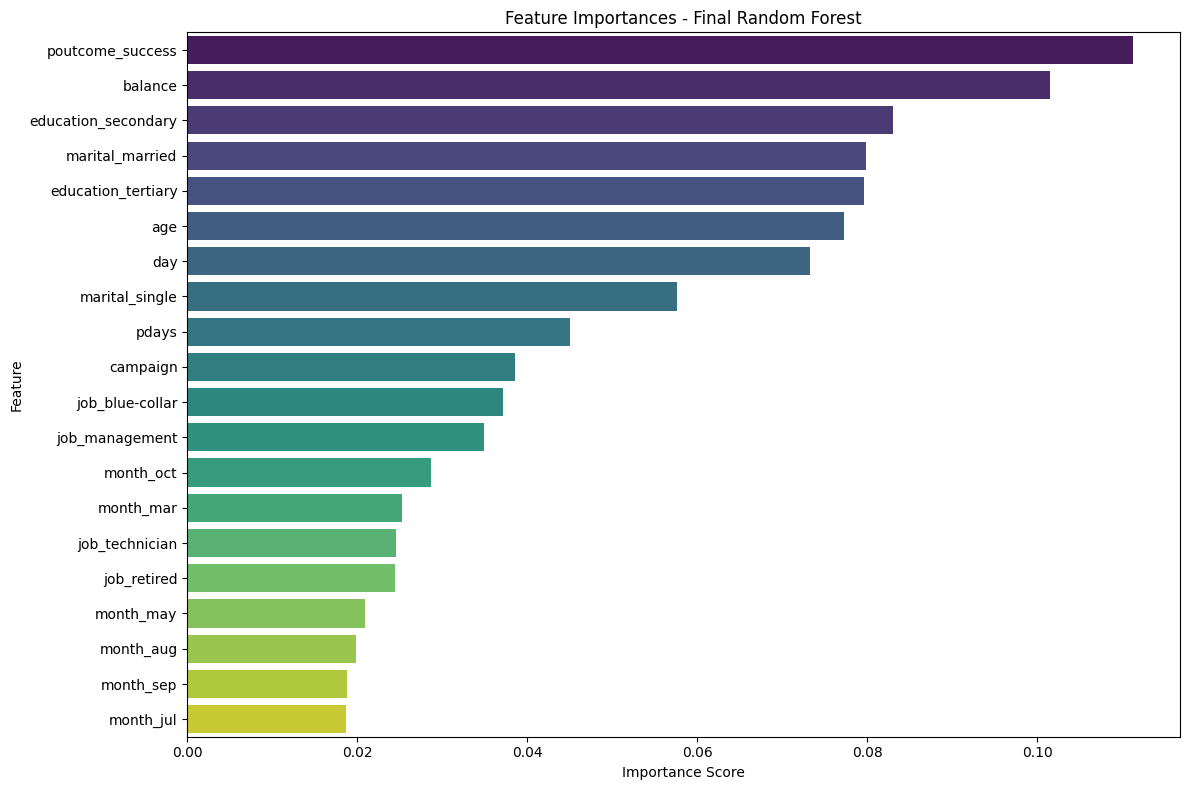

In [33]:
# Plot Feature Importance for Final Random Forest
if hasattr(final_rf, 'feature_importances_'):
    feature_importances_final = final_rf.feature_importances_
    feature_names_final = X_train_selected.columns
    importance_df_final = pd.DataFrame({
        'Feature': feature_names_final,
        'Importance': feature_importances_final
    }).sort_values(by='Importance', ascending=False)

    # Plotting the feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df_final, palette='viridis')
    plt.title("Feature Importances - Final Random Forest")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
else:
    print("The final Random Forest model does not have 'feature_importances_' attribute.")


In [34]:
# Import necessary libraries
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score
)

In [35]:
# Train and Evaluate MLPClassifier with Default Parameters
# Initialize the MLPClassifier with default parameters
mlp_default = MLPClassifier(
    hidden_layer_sizes=(64,),
    max_iter=300,
    activation='relu',
    solver='adam',
    random_state=42
)

# Train the model on the training data
mlp_default.fit(X_train, y_train)
print("\nDefault MLPClassifier model has been trained.")



Default MLPClassifier model has been trained.


In [36]:
# Make predictions on the test set
mlp_default_pred_test = mlp_default.predict(X_test)

# Make predictions on the training set
mlp_default_pred_train = mlp_default.predict(X_train)

# Calculate evaluation metrics for the default model (test set)
mlp_default_accuracy_test = accuracy_score(y_test, mlp_default_pred_test)
mlp_default_recall_test = recall_score(y_test, mlp_default_pred_test)
mlp_default_precision_test = precision_score(y_test, mlp_default_pred_test)
mlp_default_f1_test = f1_score(y_test, mlp_default_pred_test)
mlp_default_auc_test = roc_auc_score(y_test, mlp_default.predict_proba(X_test)[:,1])

# Calculate evaluation metrics for the default model (training set)
mlp_default_accuracy_train = accuracy_score(y_train, mlp_default_pred_train)
mlp_default_recall_train = recall_score(y_train, mlp_default_pred_train)
mlp_default_precision_train = precision_score(y_train, mlp_default_pred_train)
mlp_default_f1_train = f1_score(y_train, mlp_default_pred_train)
mlp_default_auc_train = roc_auc_score(y_train, mlp_default.predict_proba(X_train)[:,1])



In [37]:
# Display evaluation metrics for the default model (training set)
print("\n=========================")
print("DEFAULT MLPCLASSIFIER TRAINING SET RESULTS")
print("=========================")
print(f"Training Accuracy: {mlp_default_accuracy_train:.4f}")
print(f"Training Recall: {mlp_default_recall_train:.4f}")
print(f"Training Precision: {mlp_default_precision_train:.4f}")
print(f"Training F1-Score: {mlp_default_f1_train:.4f}")
print(f"Training AUC-ROC: {mlp_default_auc_train:.4f}")
print("\nTraining Confusion Matrix:")
print(confusion_matrix(y_train, mlp_default_pred_train))
print("\nTraining Classification Report:")
print(classification_report(y_train, mlp_default_pred_train))


DEFAULT MLPCLASSIFIER TRAINING SET RESULTS
Training Accuracy: 0.9361
Training Recall: 0.8980
Training Precision: 0.9721
Training F1-Score: 0.9336
Training AUC-ROC: 0.9778

Training Confusion Matrix:
[[31113   824]
 [ 3258 28680]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     31937
           1       0.97      0.90      0.93     31938

    accuracy                           0.94     63875
   macro avg       0.94      0.94      0.94     63875
weighted avg       0.94      0.94      0.94     63875



In [38]:
# Display evaluation metrics for the default model (test set)
print("\n=========================")
print("DEFAULT MLPCLASSIFIER TEST SET RESULTS")
print("=========================")
print(f"Test Accuracy: {mlp_default_accuracy_test:.4f}")
print(f"Test Recall: {mlp_default_recall_test:.4f}")
print(f"Test Precision: {mlp_default_precision_test:.4f}")
print(f"Test F1-Score: {mlp_default_f1_test:.4f}")
print(f"Test AUC-ROC: {mlp_default_auc_test:.4f}")
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, mlp_default_pred_test))
print("\nTest Classification Report:")
print(classification_report(y_test, mlp_default_pred_test))


DEFAULT MLPCLASSIFIER TEST SET RESULTS
Test Accuracy: 0.9219
Test Recall: 0.8826
Test Precision: 0.9579
Test F1-Score: 0.9187
Test AUC-ROC: 0.9621

Test Confusion Matrix:
[[7675  310]
 [ 937 7047]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      7985
           1       0.96      0.88      0.92      7984

    accuracy                           0.92     15969
   macro avg       0.92      0.92      0.92     15969
weighted avg       0.92      0.92      0.92     15969



In [43]:
param_distributions = {
    'hidden_layer_sizes': [(64,), (128,), (64, 64)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

mlp = MLPClassifier(
    max_iter=300,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

random_search = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_distributions,
    n_iter=20,
    cv=2,
    scoring='roc_auc',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

print("\nStarting RandomizedSearchCV for MLPClassifier Hyperparameter Tuning...")
random_search.fit(X_train, y_train)


Starting RandomizedSearchCV for MLPClassifier Hyperparameter Tuning...
Fitting 2 folds for each of 20 candidates, totalling 40 fits


RandomizedSearchCV(cv=2,
                   estimator=MLPClassifier(early_stopping=True, max_iter=300,
                                           random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': [0.0001, 0.001],
                                        'hidden_layer_sizes': [(64,), (128,),
                                                               (64, 64)],
                                        'learning_rate_init': [0.001, 0.01],
                                        'solver': ['adam']},
                   random_state=42, scoring='roc_auc', verbose=2)

In [44]:
# Retrieve the best parameters
best_params_mlp = random_search.best_params_
print("\nBest Parameters Found for MLPClassifier:")
print(best_params_mlp)


Best Parameters Found for MLPClassifier:
{'solver': 'adam', 'learning_rate_init': 0.01, 'hidden_layer_sizes': (64, 64), 'alpha': 0.0001, 'activation': 'relu'}


In [45]:
# Train and Evaluate Tuned MLPClassifier
# Initialize the MLPClassifier with the best parameters and early stopping
mlp_tuned = MLPClassifier(
    hidden_layer_sizes=best_params_mlp['hidden_layer_sizes'],
    activation=best_params_mlp['activation'],
    solver=best_params_mlp['solver'],
    alpha=best_params_mlp['alpha'],
    learning_rate_init=best_params_mlp['learning_rate_init'],
    max_iter=300,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1
)

# Train the tuned model on the training data
mlp_tuned.fit(X_train, y_train)
print("\nTuned MLPClassifier model has been trained.")

# Make predictions on the test set
mlp_tuned_pred_test = mlp_tuned.predict(X_test)

# Make predictions on the training set
mlp_tuned_pred_train = mlp_tuned.predict(X_train)

# Calculate evaluation metrics for the tuned model (test set)
mlp_tuned_accuracy_test = accuracy_score(y_test, mlp_tuned_pred_test)
mlp_tuned_recall_test = recall_score(y_test, mlp_tuned_pred_test)
mlp_tuned_precision_test = precision_score(y_test, mlp_tuned_pred_test)
mlp_tuned_f1_test = f1_score(y_test, mlp_tuned_pred_test)
mlp_tuned_auc_test = roc_auc_score(y_test, mlp_tuned.predict_proba(X_test)[:,1])

# Calculate evaluation metrics for the tuned model (training set)
mlp_tuned_accuracy_train = accuracy_score(y_train, mlp_tuned_pred_train)
mlp_tuned_recall_train = recall_score(y_train, mlp_tuned_pred_train)
mlp_tuned_precision_train = precision_score(y_train, mlp_tuned_pred_train)
mlp_tuned_f1_train = f1_score(y_train, mlp_tuned_pred_train)
mlp_tuned_auc_train = roc_auc_score(y_train, mlp_tuned.predict_proba(X_train)[:,1])



Tuned MLPClassifier model has been trained.


In [46]:
# Display evaluation metrics for the tuned model (training set)
print("\n=========================")
print("TUNED MLPCLASSIFIER TRAINING SET RESULTS")
print("=========================")
print(f"Training Accuracy: {mlp_tuned_accuracy_train:.4f}")
print(f"Training Recall: {mlp_tuned_recall_train:.4f}")
print(f"Training Precision: {mlp_tuned_precision_train:.4f}")
print(f"Training F1-Score: {mlp_tuned_f1_train:.4f}")
print(f"Training AUC-ROC: {mlp_tuned_auc_train:.4f}")
print("\nTraining Confusion Matrix:")
print(confusion_matrix(y_train, mlp_tuned_pred_train))
print("\nTraining Classification Report:")
print(classification_report(y_train, mlp_tuned_pred_train))


TUNED MLPCLASSIFIER TRAINING SET RESULTS
Training Accuracy: 0.9279
Training Recall: 0.8831
Training Precision: 0.9700
Training F1-Score: 0.9245
Training AUC-ROC: 0.9690

Training Confusion Matrix:
[[31066   871]
 [ 3733 28205]]

Training Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     31937
           1       0.97      0.88      0.92     31938

    accuracy                           0.93     63875
   macro avg       0.93      0.93      0.93     63875
weighted avg       0.93      0.93      0.93     63875



In [47]:
# Display evaluation metrics for the tuned model (test set)
print("\n=========================")
print("TUNED MLPCLASSIFIER TEST SET RESULTS")
print("=========================")
print(f"Test Accuracy: {mlp_tuned_accuracy_test:.4f}")
print(f"Test Recall: {mlp_tuned_recall_test:.4f}")
print(f"Test Precision: {mlp_tuned_precision_test:.4f}")
print(f"Test F1-Score: {mlp_tuned_f1_test:.4f}")
print(f"Test AUC-ROC: {mlp_tuned_auc_test:.4f}")
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, mlp_tuned_pred_test))
print("\nTest Classification Report:")
print(classification_report(y_test, mlp_tuned_pred_test))


TUNED MLPCLASSIFIER TEST SET RESULTS
Test Accuracy: 0.9213
Test Recall: 0.8758
Test Precision: 0.9635
Test F1-Score: 0.9175
Test AUC-ROC: 0.9620

Test Confusion Matrix:
[[7720  265]
 [ 992 6992]]

Test Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.92      7985
           1       0.96      0.88      0.92      7984

    accuracy                           0.92     15969
   macro avg       0.92      0.92      0.92     15969
weighted avg       0.92      0.92      0.92     15969



In [48]:
# Compare Default and Tuned MLPClassifier Models
# Create a DataFrame to compare metrics
mlp_metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'Recall', 'Precision', 'F1-Score', 'AUC-ROC'],
    'Default MLP': [mlp_default_accuracy_test, mlp_default_recall_test, mlp_default_precision_test, mlp_default_f1_test, mlp_default_auc_test],
    'Tuned MLP': [mlp_tuned_accuracy_test, mlp_tuned_recall_test, mlp_tuned_precision_test, mlp_tuned_f1_test, mlp_tuned_auc_test]
})

print("\nComparison of Default and Tuned MLPClassifier Models:")
print(mlp_metrics_comparison)



Comparison of Default and Tuned MLPClassifier Models:
      Metric  Default MLP  Tuned MLP
0   Accuracy     0.921911   0.921285
1     Recall     0.882640   0.875752
2  Precision     0.957863   0.963484
3   F1-Score     0.918715   0.917525
4    AUC-ROC     0.962059   0.962023


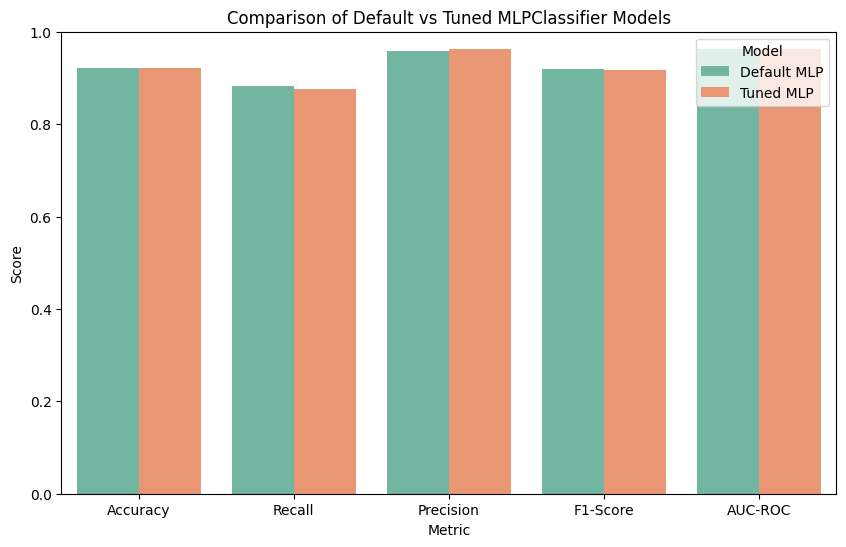

In [49]:
# Plot comparison
mlp_metrics_melted = mlp_metrics_comparison.melt(id_vars='Metric', var_name='Model', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', hue='Model', data=mlp_metrics_melted, palette='Set2')
plt.title('Comparison of Default vs Tuned MLPClassifier Models')
plt.ylim(0,1)
plt.legend(title='Model')
plt.show()